# Deep Learning

Build a Convolutional Neural Network. Train it on MNIST training set and test it
on testing set. You can design your architecture or use the architecture introduced
in LeCun’s paper

> Import libraries

In [1]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from utils import *

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Running on : ',device)

Running on :  cuda


>> Generate Dataloaders for train, validation and test data.

<p> To Download the dataset to device, set the download_YN flag to true
</p>

In [3]:
## Variables

download_YN = False
visualize_YN = True
np.random.seed(1024)
validation_split = 0.2

In [5]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# Normalize
norm = transforms.Normalize((MNIST_GLOBAL_MEAN,), (MNIST_SD,))
transform_lst = transforms.Compose([transforms.ToTensor(),norm])

# Read Train dataset
train_dataset = datasets.MNIST(root='./dataset/', train=True,download=download_YN, transform=transform_lst)

# Randomly split train dataset to train and validation with ratio 1:0.2
all_point_idx = list(range(len(train_dataset)))
np.random.shuffle(all_point_idx)        # Shuffle indices
slice_idx = int(np.floor(validation_split * len(train_dataset)))     # index to slice at
train_idx = all_point_idx[slice_idx:] 
train_sampler = SubsetRandomSampler(train_idx)


valid_dataset = datasets.MNIST(root='./dataset/', train=True,download=download_YN, transform=transform_lst)
valid_idx = all_point_idx[:slice_idx]
valid_sampler = SubsetRandomSampler(valid_idx)

# Generate Python iterable over dataset to train and test
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128, sampler=train_sampler, num_workers=1, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, sampler=valid_sampler, num_workers=1, pin_memory=True)

test_dataset = datasets.MNIST(root='./dataset/',transform=transform_lst,train=False,download=download_YN)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle = True, pin_memory=True)

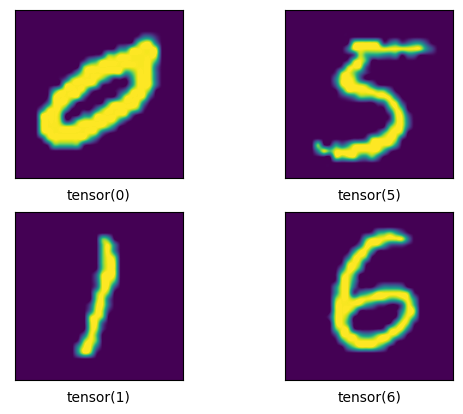

In [6]:
if visualize_YN:
    # Visualize a loaded sampler
    data_small = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
    data_iter = iter(data_small)
    X, classes_ = data_iter.next()
    X = X.numpy()
    fig, axes = plt.subplots(2, 2)
    for i, ax in enumerate(axes.flat):
        label = str(classes_[i])
        xlabel = label
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X[i, 0, :, :], interpolation='spline16')
    plt.show()
    

>> Method to evaluate model 

In [22]:
def get_score(loader, model)->list:
    ''' Returns score evaluated for data in 'loader' using 'model' '''
    score = []
    model.eval()
    count_true = 0
    total_ = 0    
    with torch.no_grad():
        for image, label in loader:
            #print(' inside for x, y in loader')
            image = image.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            # Predict
            _, y_hat = (model(image)).max(1)
            count_true += (y_hat == label).sum()
            total_ += y_hat.size(0)
        s = float(count_true) / total_
        score.append(s)
        print('Correct prediction for %d / %d samples. Accuracy = (%.2f)' % (count_true, total_, 100 * s))
        return score


>> Train method for any model

In [7]:
def train(model, optimizer, epochs=1):
    validation_score = []
    lst_loss = []
    model = model.to(device=device)
    for i in range(epochs):
        # print(i)
        for batch, (img, lbl) in enumerate(train_loader):
            # print(img.shape)
            # print(lbl.shape)
            model.train()
            img = img.to(device=device, dtype=torch.float32)
            lbl = lbl.to(device=device, dtype=torch.long)
            # print(img.shape)
            # print(lbl.shape)
            scores = model(img)
            # Computes the cross entropy loss between input and target.
            loss = F.cross_entropy(scores, lbl)
            # Optimizer
            optimizer.zero_grad()
            # Compute the gradient of current tensor w.r.t. graph leaves
            loss.backward()
            # Step
            optimizer.step()
            # Print result every 50th step
            if batch % 50 == 0:
                # Print Loss
                print('Epoch %d, Loss = %.4f' % (batch, loss.item()))
                # Evaluate accuracy and print
                validation_score.append(get_score(valid_loader, model))
                lst_loss.append(loss.item())
    best_val = []
    for a in validation_score:
        best_val.append(a[np.argmax(a)])
    return best_val,lst_loss


# Define model

In [8]:
filter = 3

neural_net = nn.Sequential(#                                               Shape
    # (Conv->BatchNorm->Relu) *2                                 1 ---->  32
    nn.Conv2d(1, 32, 3, 1),    nn.BatchNorm2d(32),    nn.ReLU(),
    nn.Conv2d(32, 64,3,1),    nn.BatchNorm2d(64),    nn.ReLU(),
    #  2x2 Max-pool
    nn.MaxPool2d((2, 2)),
    # (Conv->BatchNorm->Relu) *2                                 32 ---->  64 
    nn.Conv2d(64, 64, filter, padding=1),    nn.BatchNorm2d(64),    nn.ReLU(),
    nn.Conv2d(64, 64, filter, padding=1),    nn.BatchNorm2d(64),    nn.ReLU(),
    #  2x2 Max-pool
    nn.MaxPool2d((2, 2)),
    # (Conv->BatchNorm->Relu) *3                                 64 ---->  128
    nn.Conv2d(64, 128, filter, padding=1),    nn.BatchNorm2d(128),    nn.ReLU(),
    nn.Conv2d(128, 128, filter, padding=1),    nn.BatchNorm2d(128),    nn.ReLU(),
    nn.Conv2d(128, 128, filter, padding=1),    nn.BatchNorm2d(128),    nn.ReLU(),
    #  2x2 Max-pool
    nn.MaxPool2d((2, 2)),
    Flatten(),
    # FC
    nn.Dropout(0.2, inplace=True),  ## Drop-out
    nn.Linear(128 * 3 * 3, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

# # Debug Input / output dimensions
# def forward(x):
#   for layer in model:
#       print(x.size())
#       x = layer(x)
#   return x
# x = torch.randn(128, 1, 28, 28)
# forward(x)


# Model Summary

In [25]:
neural_net

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

# Train and Evaluate

In [26]:
# Define optimizers to evaluate with:
optimizers = [optim.SGD(neural_net.parameters(), lr=0.0025, momentum=0.9, nesterov=True),
              optim.Adagrad(neural_net.parameters(), lr=0.0023, lr_decay=0.75),
              optim.Adam(neural_net.parameters(), lr=0.0015)]


## *SGD*

In [28]:
model = neural_net
validation_score_sgd = train(model, optimizers[0], epochs=5)


Epoch 0, Loss = 0.1282
Correct prediction for 11660 / 12000 samples. Accuracy = (97.17)
Epoch 50, Loss = 0.0762
Correct prediction for 11725 / 12000 samples. Accuracy = (97.71)
Epoch 100, Loss = 0.0747
Correct prediction for 11728 / 12000 samples. Accuracy = (97.73)
Epoch 150, Loss = 0.0321
Correct prediction for 11752 / 12000 samples. Accuracy = (97.93)
Epoch 200, Loss = 0.0364
Correct prediction for 11809 / 12000 samples. Accuracy = (98.41)
Epoch 250, Loss = 0.0791
Correct prediction for 11805 / 12000 samples. Accuracy = (98.38)
Epoch 300, Loss = 0.0365
Correct prediction for 11811 / 12000 samples. Accuracy = (98.42)
Epoch 350, Loss = 0.0288
Correct prediction for 11817 / 12000 samples. Accuracy = (98.47)
Epoch 0, Loss = 0.0176
Correct prediction for 11774 / 12000 samples. Accuracy = (98.12)
Epoch 50, Loss = 0.0213
Correct prediction for 11809 / 12000 samples. Accuracy = (98.41)
Epoch 100, Loss = 0.0513
Correct prediction for 11834 / 12000 samples. Accuracy = (98.62)
Epoch 150, Loss 

>> Get Test accuraccy

In [32]:
test_acc_sgd = get_score(test_loader, model)

Correct prediction for 9934 / 10000 samples. Accuracy = (99.34)


In [33]:
print("Best Validation Accuraccy:")
validation_score_sgd[0][np.argmax(validation_score_sgd[0])]

Best Validation Accuraccy:


0.99175

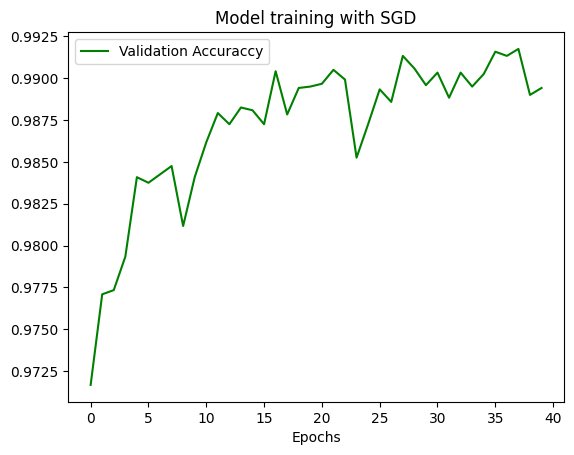

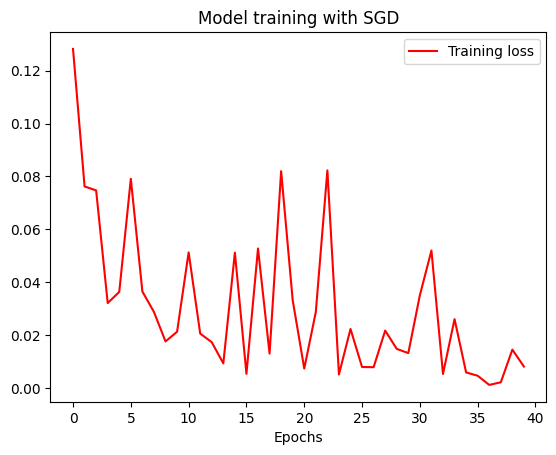

In [35]:
plt.plot(range(len(validation_score_sgd[0])), validation_score_sgd[0], 'g', label='Validation Accuraccy')
plt.title('Model training with SGD')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.plot(range(len(validation_score_sgd[0])), validation_score_sgd[1], 'r', label='Training loss')
plt.title('Model training with SGD')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## *Adam*

In [36]:
model = neural_net
validation_score_adam = train(model, optimizers[2], epochs=10)

Epoch 0, Loss = 0.0090
Correct prediction for 2100 / 12000 samples. Accuracy = (17.50)
Epoch 50, Loss = 0.0528
Correct prediction for 11581 / 12000 samples. Accuracy = (96.51)
Epoch 100, Loss = 0.1101
Correct prediction for 11654 / 12000 samples. Accuracy = (97.12)
Epoch 150, Loss = 0.0445
Correct prediction for 11659 / 12000 samples. Accuracy = (97.16)
Epoch 200, Loss = 0.0586
Correct prediction for 11776 / 12000 samples. Accuracy = (98.13)
Epoch 250, Loss = 0.0519
Correct prediction for 11740 / 12000 samples. Accuracy = (97.83)
Epoch 300, Loss = 0.0326
Correct prediction for 11808 / 12000 samples. Accuracy = (98.40)
Epoch 350, Loss = 0.0366
Correct prediction for 11798 / 12000 samples. Accuracy = (98.32)
Epoch 0, Loss = 0.0577
Correct prediction for 11646 / 12000 samples. Accuracy = (97.05)
Epoch 50, Loss = 0.0499
Correct prediction for 11809 / 12000 samples. Accuracy = (98.41)
Epoch 100, Loss = 0.0826
Correct prediction for 11831 / 12000 samples. Accuracy = (98.59)
Epoch 150, Loss =

In [40]:
test_acc_adam = get_score(test_loader, model)

Correct prediction for 9927 / 10000 samples. Accuracy = (99.27)


In [41]:
validation_score_adam[0][np.argmax(validation_score_adam[0])]

0.99325

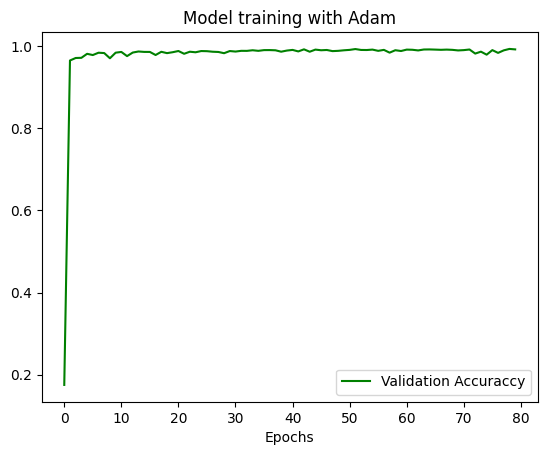

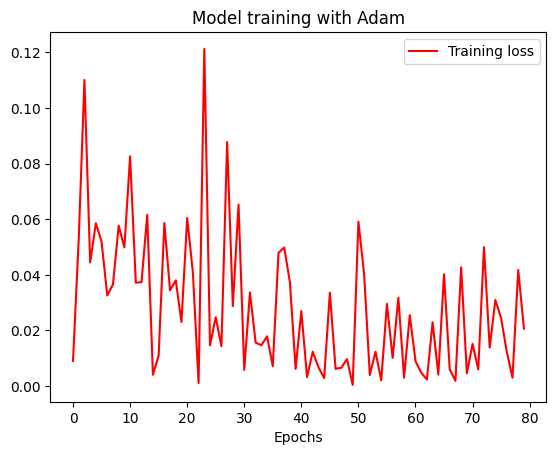

In [44]:
plt.plot(range(len(validation_score_adam[0])), validation_score_adam[0], 'g', label='Validation Accuraccy')
plt.title('Model training with Adam')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.plot(range(len(validation_score_adam[0])), validation_score_adam[1], 'r', label='Training loss')
plt.title('Model training with Adam')
plt.xlabel('Epochs')
plt.legend()
plt.show()

https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123 :  For Data loading